In [1]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import logging
import sys
sys.path.append('../')
from helper import defaultPars

c = 3e8

FORMAT = '%(levelname)s: %(message)s at %(asctime)s'
logging.basicConfig(format=FORMAT,datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger()

plt.rcParams.update(defaultPars)

### Results to be plotted

In [2]:
filesLabels = {
            #  'Default' : '../pp2chi0chi0J_nosmear_scan/Events/run_03/ddmH_mS_500_m1_248_dm_94_ctau_3.0_delphes_events.root',
             'sa = 0.05' : '../pp2chi0chi0J_nosmear_scan/Events/run_04/ddmH_mS_500_m1_244_dm_90_ctau_3.0_delphes_events.pcl',
             'sa = 0.05, dm1 = 2' : '../pp2chi0chi0J_nosmear_scan/Events/run_05/ddmH_mS_500_m1_249_dm_95_ctau_3.0_delphes_events.pcl',
             'sa = 0.05, dm1 = 2, ctau' : '../pp2chi0chi0J_nosmear_scan/Events/run_06/ddmH_mS_500_m1_249_dm_95_ctau_3.0_delphes_events.pcl',
            #  'sa = 0.05 dm1 = 4' : '../pp2chi0chi0J_nosmear_scan/Events/run_03/ddmH_mS_500_m1_248_dm_94_ctau_3.0_delphes_events.pcl'
             }

In [3]:
dfDict = {}
for label, file in filesLabels.items():
    dfDict[label] = pd.read_pickle(file)

In [4]:
df = dfDict['sa = 0.05']
# df[df['eventRecord'] == 'N']
idx = pd.IndexSlice
df.loc[:,'N-1',:]

,,$\beta$,$\rho_{\rm dec}$ (m),$z$ (m),$t_{\rm readout}$ (ns)
event,illp,,,,
0,0,0.981785,2.814133,98.424086,6.093679
14,0,0.789426,0.925179,2.072738,2.019621
25,0,0.691529,1.152774,-2.324622,3.860828
51,0,0.900477,0.433593,-6.806086,2.514240
115,0,0.954925,15.330014,39.391926,6.655467
...,...,...,...,...,...
26087,0,0.896985,0.811885,9.406615,3.616932
26088,0,0.897913,0.088257,2.541217,0.964314
26116,0,0.516106,0.358790,-1.536585,4.934868


### Plot Event Record Stats

In [ ]:
countNm1 = 0
countN = 0
for ievt,event in df.groupby(level=0):
    print(ievt)
    print(event.T)
    if len(event) != 2:
        continue

0
event                           0
eventRecord                   N-1
illp                            0
$\beta$                  0.981785
$\rho_{\rm dec}$ (m)     2.814133
$z$ (m)                 98.424086
$t_{\rm readout}$ (ns)   6.093679


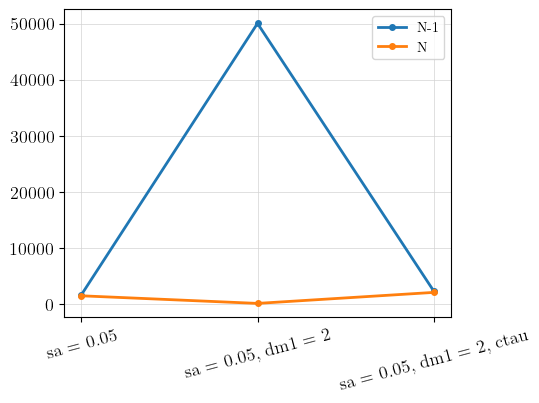

In [ ]:
x = []
y = []
for label,df in dfDict.items():
    x.append(label)
    y.append([len(df.loc[:,'N-1',:]),len(df.loc[:,'N',:])])
y = np.array(y)
xvals = list(range(len(x)))
plt.plot(xvals,y[:,0],label='N-1',marker='o')
plt.plot(xvals,y[:,1],label='N',marker='o')
plt.xticks(xvals,x,rotation=15)
plt.legend()
# plt.yscale('log')
plt.show()

## Plot Distributions

In [42]:
plot_variables = []
for df in dfDict.values():
    plot_variables += list(df.columns)

plot_variables = list(set([c for c in plot_variables if c not in []]))

colors = dict(zip(filesLabels.keys(),plt.colormaps['Paired'].colors[1:2*len(filesLabels):2]))

/home/lessa/.local/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


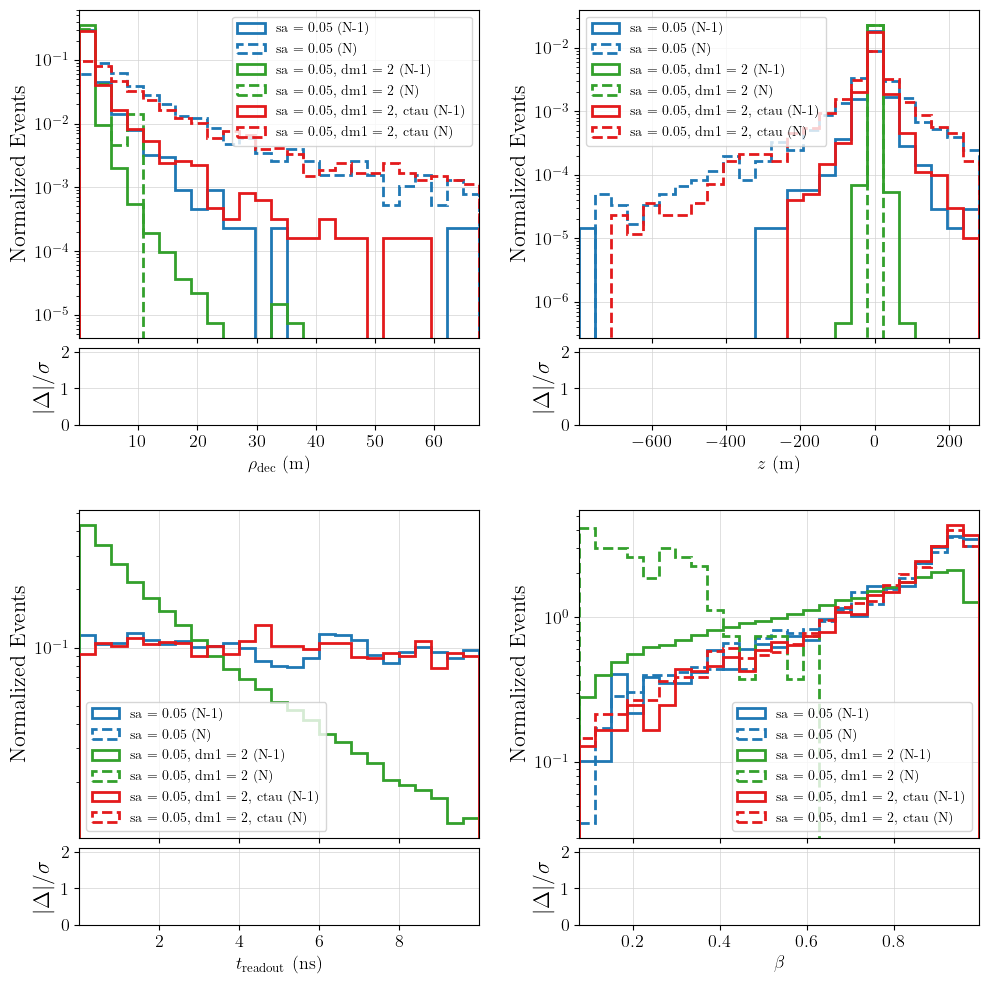

In [43]:
nrows = 3
ncols = int(np.ceil(len(plot_variables)/nrows))
# ncols = 4

# Create a figure for the nrows x ncols grid of plots
# Increased figsize to accommodate subplots
w,h = 5*ncols,5*nrows
fig = plt.figure(figsize=(w,h))

# Adjust overall subplot parameters
fig.subplots_adjust(hspace=0.4, wspace=0.3)

irow = 0
icol = 0
for i,var in enumerate(plot_variables):
    ymax = 0.0

    # Create a GridSpec for the current subplot cell.
    # This divides the current subplot space into 2 rows and 1 column,
    # with the top row 3 times taller than the bottom (for histogram vs ratio).
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 0.7                                                  ])
    # Place the gridspec within the overall figure grid using its position
    # For a nrows x ncols grid, (row, col) translates to (i // ncols, i % ncols) 0.7
    toppadding = 0.07 # space for title
    wpadding = 0.2 #width space between plots
    hpadding = 0.05 #height space between plots
    wspace = 1.0-wpadding*(ncols-1) # total width available for plots
    hspace = 1.0-toppadding-hpadding*(nrows-1) # total height available for plots
    gs.update(left=icol*(1.0/ncols),
                right=(icol)*(1.0/ncols) + wspace/ncols,
                top=1.0-toppadding - (irow)*(1.0/nrows),
                bottom=1.0-toppadding - (irow)*(1.0/nrows) -hspace/nrows,
                hspace=0.05) # No horizontal space between histogram and ratio within a cell

    icol += 1
    if icol == ncols:
        icol = 0
        irow += 1

    # Add the GridSpec to the main figure's grid
    # The `add_subplot` method takes GridSpec as an argument for placement
    ax_ratio = fig.add_subplot(gs[1, 0]) # Bottom part for ratio, sharing x-axis with ax_hist
    ax_hist = fig.add_subplot(gs[0, 0]) # Top part for histograms
    

 
    # Add Tobias curve if found
    y0 = None
    var_bins = 25
    for label,df in dfDict.items():
        color = colors[label]
        for evtRecord in ['N-1','N']:
            if evtRecord == 'N-1':
                ls = 'solid'
            else:
                ls = 'dashed'
            df_record = df.loc[:,evtRecord,:]
            y,bins,p = ax_hist.hist(df_record[var],bins=var_bins,histtype='step',density=True,
                    linewidth=2,linestyle=ls,label=f'{label} ({evtRecord})',color=color)
            var_bins = bins
            yerr = np.sqrt(y)
            bin_center = (bins[:-1]+bins[1:])/2.0
            # ax_hist.errorbar(bin_center,y,yerr = yerr,
            #                 # marker = '.',
            #                 color=color,
            #                 # color=p[-1].get_facecolor(),
            #                 # drawstyle = 'steps-mid',label=label,
            #                 linewidth=2,
            #                 # linestyle=ls,
            #                 fmt="o")
        
    
            # Plot diff
            # if y0 is None:
            #     y0 = y
            #     y0Err = yerr
            # else:
            #     dy = y-y0
            #     dy_error = np.sqrt(yerr**2 + y0Err**2)
            #     ddy = np.abs(np.divide(dy, dy_error, out=np.zeros_like(dy_error), where= dy_error != 0))
            #     # ddy = np.array([dy[i]/dyerr for i,dyerr in enumerate(dynp.where(dy_error > 0., dy/dy_error,0.0)
            #     ax_ratio.hist(bin_center,weights=ddy,bins=bins,histtype='step',
            #                     linewidth=2,linestyle=ls,label=label,color=color)
    

    
        
    
    ax_hist.set_ylabel('Normalized Events')
    ax_hist.set_xticklabels([])
    ax_hist.set_yscale('log')
    ax_hist.set_xlim(min(bins),max(bins))
    if i >= 0:
        ax_hist.legend()

    ax_ratio.set_xlabel(var,fontsize=13)
    ax_ratio.set_ylabel(r'$|\Delta|/\sigma$')
    ax_ratio.set_yticks([0.0,1.0,2.0])
    ax_ratio.set_ylim(0.0,2.1)
    ax_ratio.set_xlim(min(bins),max(bins))
    


plt.show()